# Module 4 Project
### Khairul Omar, Stuti Singh & Aleksandar Gavokic

# Executive summary

Insert executive summary here

# 1. Data import

In [1200]:
import pandas as pd
pd.set_option('display.max_rows', 540)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from textwrap import wrap

import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, scale, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error

from itertools import combinations

import statsmodels.api as sm
from statsmodels.formula.api import ols


In [1215]:
# Import raw data
raw = pd.read_csv('analytic_data2019.csv', skiprows=[1,2])
display(raw.shape)
display(raw.head())

(3193, 534)

,State FIPS Code,County FIPS Code,5-digit FIPS Code,State Abbreviation,Name,Release Year,County Ranked (Yes=1/No=0),Premature death raw value,Premature death numerator,Premature death denominator,...,Male population 18-44 raw value,Male population 45-64 raw value,Male population 65+ raw value,Total male population raw value,Female population 0-17 raw value,Female population 18-44 raw value,Female population 45-64 raw value,Female population 65+ raw value,Total female population raw value,Population growth raw value
0,1,0,1000,AL,Alabama,2019,NaN,9917.232898,80440.0,13636816.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1001,AL,Autauga County,2019,1.0,8824.057123,815.0,156132.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,1003,AL,Baldwin County,2019,1.0,7224.632160,2827.0,576496.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,5,1005,AL,Barbour County,2019,1.0,9586.165037,451.0,72222.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,7,1007,AL,Bibb County,2019,1.0,11783.543675,445.0,63653.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Data Cleansing

In [1216]:
# Remove unnecessary columns
filter_out = ['numerator', 'denominator', 'CI low', 'CI high']
df = raw.copy()
for f in filter_out:
    df = df.loc[:, ~df.columns.str.contains(f)]

# Clean up column names
replace_dict = {' raw value':'', ' - ':'_', '-':'_', '=':'', '/':'_',
                '(':'', ')':'', '.':'', '+':' above', '%':'Percent', ' ':'_'}
for key, value in replace_dict.items():
    df.columns = df.columns.str.replace(key, value)

# Drop column if data is > 20% null
df = df.drop(df.loc[:,list((100*(df.isnull().sum()/len(df.index))>20))].columns, 1)

# Replace NaN values with the state's median, i.e. when County_FIPS_Code=0
df = df.fillna(df.loc[df.County_FIPS_Code==0].median())

# Remove state-level data, keep only county-level data
df = df.drop(df[df.County_FIPS_Code==0].index)

cols = list(df.columns)
df.shape

(3142, 81)

# 3. Data Exploration (EDA)

### 3.1 Overview of data via plots

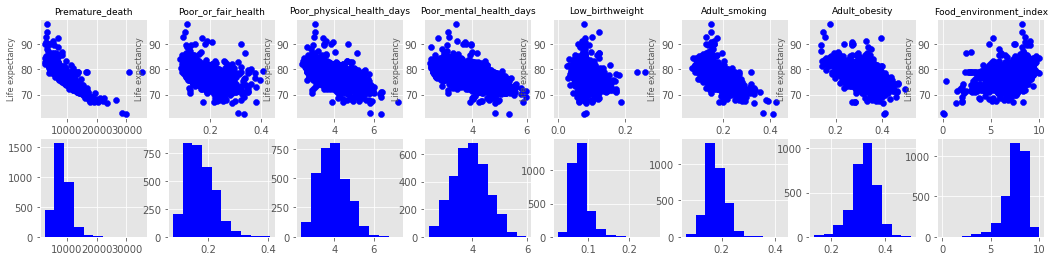

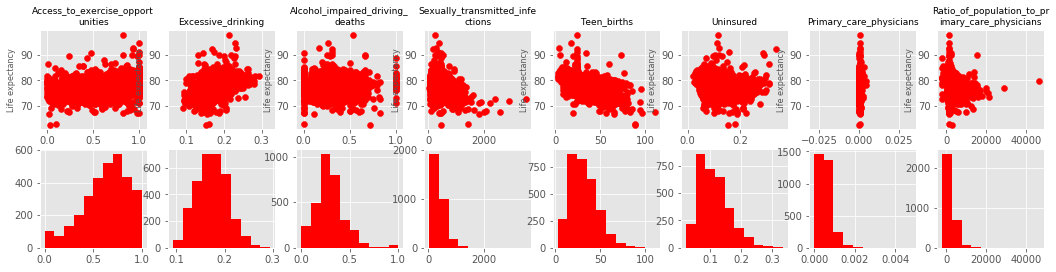

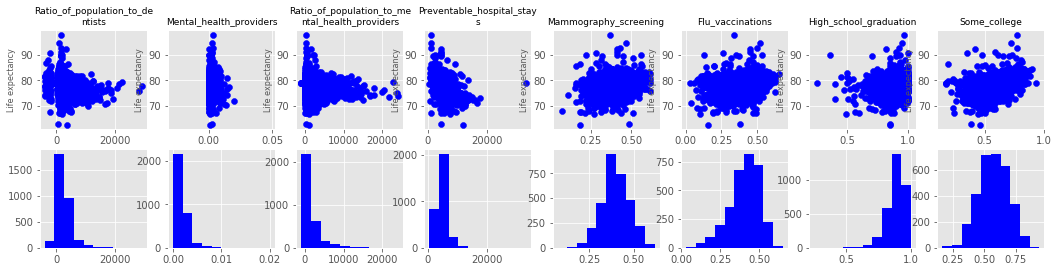

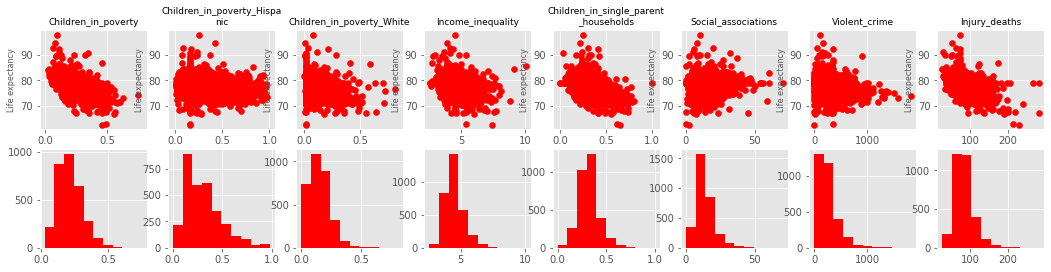

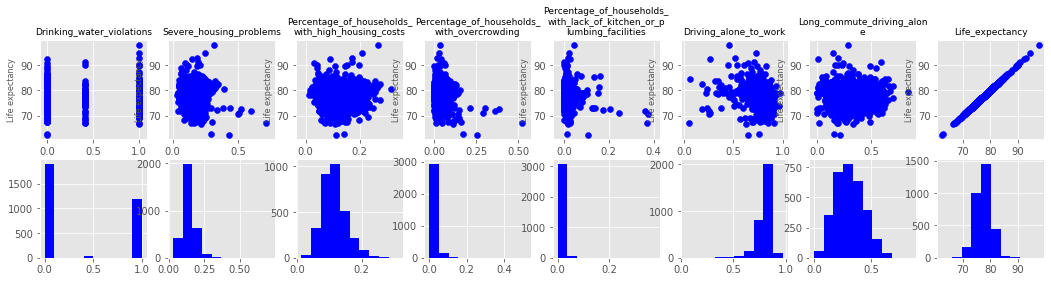

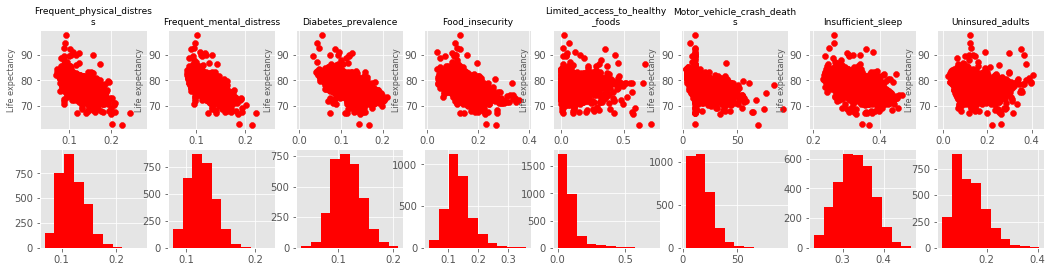

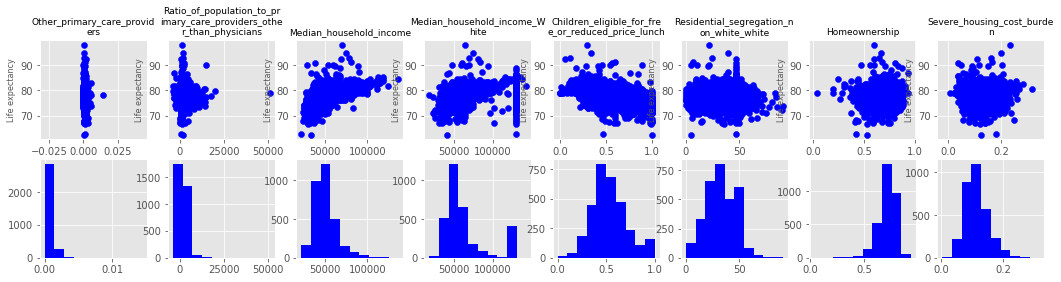

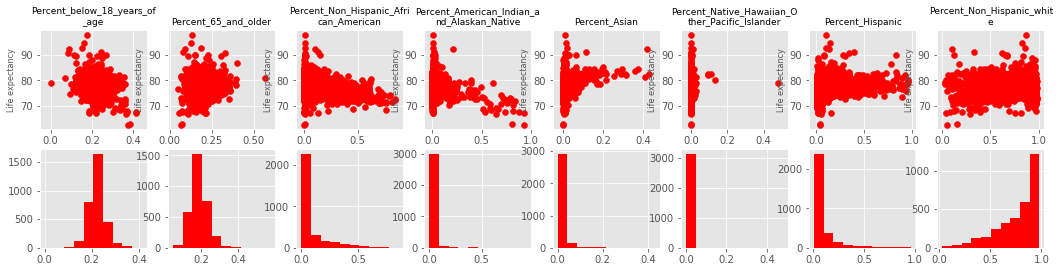

In [1199]:
# Plot all columns using scatter plot & histogram
k = 7 # first numerical column starts at 7, columns 0-6 are string columns
num_of_numerical_cols = df.drop(df.iloc[:, :k], axis = 1).shape[1]
num_of_plots_per_row = 8
num_of_sets = num_of_numerical_cols // (num_of_plots_per_row + 1)

for r, s in enumerate(range(num_of_sets)):
    color = 'blue' if (r % 2) == 0 else 'red'
    x1 = k
    x2 = k + num_of_plots_per_row
    k = k + num_of_plots_per_row + 1
    r = r * 2
    dfplot = df.iloc[:, x1:x2]
    cols_to_plot = list(dfplot.columns)

    fig, axes = plt.subplots(nrows=2, ncols=len(cols_to_plot), figsize=(18,4))
    for n, xcol in enumerate(cols_to_plot):
        axes[0,n].set_title("\n".join(wrap(xcol, 25)), fontsize=9)
        axes[0,n].scatter(dfplot[xcol], df.Life_expectancy, color=color)
        axes[0,n].set_ylabel('Life expectancy', fontsize=8)
        axes[1,n].hist(dfplot[xcol], color=color)       
    plt.show()

# 4. Evaluate predictors

### 4.1 Evaluate predictors (i) : Correlation of predictors vs. target

In [1217]:
# Calculate correlation coeff with LIFE EXPECTENCY for all predictors
df = df.iloc[:, 7:]
cols = list(df.columns)
corr_list = []

for col in cols:    
    # Correlation with x    
    corr = stats.pearsonr(df[col], df.Life_expectancy)    
    # Correlation with log x
    transformer = Normalizer().fit([df[col]])
    t = transformer.transform([df[col]])   
    if df[col].min() <= 0:
        corrlog = 0
    else:
        corrlog = stats.pearsonr(np.log(t[0]), df.Life_expectancy)[0]
    # Output list
    corr_list.append([abs(round(corr[0],3)), abs(round(corrlog, 3)), col])

# Show sorted list of columns and correlations between life expectancy vs. column and log(column)
corr_list = sorted(corr_list, key=lambda x: x[0], reverse=True)
print('Correlation between all predictors (original & log transformed) vs. Life expectancy:')
display(corr_list[0:20])

# Show top 20:

Correlation between all predictors (original & log transformed) vs. Life expectancy:


[[1.0, 0.999, 'Life_expectancy'],
 [0.927, 0.938, 'Premature_age_adjusted_mortality'],
 [0.869, 0.902, 'Premature_death'],
 [0.697, 0.691, 'Adult_smoking'],
 [0.689, 0.685, 'Frequent_mental_distress'],
 [0.671, 0.674, 'Frequent_physical_distress'],
 [0.666, 0.663, 'Poor_physical_health_days'],
 [0.658, 0.656, 'Teen_births'],
 [0.645, 0.646, 'Diabetes_prevalence'],
 [0.641, 0.651, 'Children_in_poverty'],
 [0.634, 0.625, 'Poor_mental_health_days'],
 [0.633, 0.658, 'Poor_or_fair_health'],
 [0.625, 0.624, 'Physical_inactivity'],
 [0.618, 0.645, 'Median_household_income'],
 [0.595, 0.597, 'Food_insecurity'],
 [0.543, 0.541, 'Adult_obesity'],
 [0.54, 0.568, 'Injury_deaths'],
 [0.538, 0.543, 'Excessive_drinking'],
 [0.531, 0.569, 'Motor_vehicle_crash_deaths'],
 [0.528, 0.529, 'Insufficient_sleep']]

In [1218]:
# Top 10 strongest correlation with LIFE EXPECTANCY, removing the first 2 which are not relevant:

top_predictors = list(map(lambda x: x[2], corr_list[3:13]))
print('Top 10 strongest linear correlation with Life Expectancy:')
display(top_predictors)

Top 10 strongest linear correlation with Life Expectancy:


['Adult_smoking',
 'Frequent_mental_distress',
 'Frequent_physical_distress',
 'Poor_physical_health_days',
 'Teen_births',
 'Diabetes_prevalence',
 'Children_in_poverty',
 'Poor_mental_health_days',
 'Poor_or_fair_health',
 'Physical_inactivity']

### 4.2 Evaluate predictors (ii) : Multicollinearity between predictors

In [1219]:
# Check correlation between ALL columns - to avoid multicollinearity
combo1 = list(combinations(top_predictors, 2))
corr_list1 = []
for comb in combo1:
    corr = stats.pearsonr(df[comb[0]], df[comb[1]])
    corr_list1.append([abs(round(corr[0],3)), comb[0], comb[1]])  
    
# Show sorted list of columns and correlations between life expectancy vs. column and log(column)
corr_list1 = sorted(corr_list1, key=lambda x: x[0], reverse=True)
print('Correlation between predictors to avoid multicollinearity:')
display(corr_list1[0:20])

# Show top 20:

Correlation between predictors to avoid multicollinearity:


[[0.982, 'Frequent_physical_distress', 'Poor_physical_health_days'],
 [0.956, 'Frequent_mental_distress', 'Frequent_physical_distress'],
 [0.954, 'Frequent_mental_distress', 'Poor_physical_health_days'],
 [0.953, 'Frequent_mental_distress', 'Poor_mental_health_days'],
 [0.93, 'Frequent_physical_distress', 'Poor_or_fair_health'],
 [0.92, 'Poor_physical_health_days', 'Poor_mental_health_days'],
 [0.88, 'Poor_physical_health_days', 'Poor_or_fair_health'],
 [0.878, 'Frequent_physical_distress', 'Poor_mental_health_days'],
 [0.847, 'Frequent_mental_distress', 'Poor_or_fair_health'],
 [0.832, 'Children_in_poverty', 'Poor_or_fair_health'],
 [0.821, 'Adult_smoking', 'Frequent_mental_distress'],
 [0.815, 'Adult_smoking', 'Frequent_physical_distress'],
 [0.815, 'Frequent_physical_distress', 'Children_in_poverty'],
 [0.805, 'Adult_smoking', 'Poor_physical_health_days'],
 [0.767, 'Frequent_mental_distress', 'Children_in_poverty'],
 [0.756, 'Poor_physical_health_days', 'Children_in_poverty'],
 [0.7

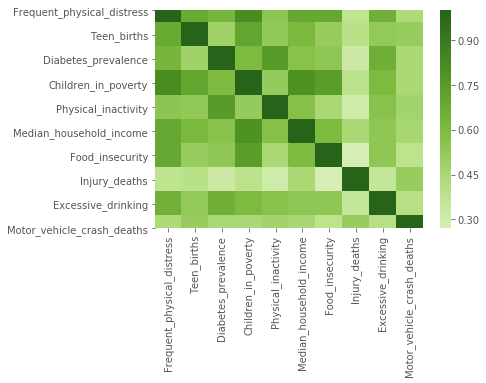

In [1213]:
# Plot correlation heatmap between top 10 predictors from section 4.1
sns.heatmap(abs(df[top_predictors[:]].corr()), cmap="PiYG", center=0)

### 4.3 Evaluate predictors (iii) : Interaction between all predictors

In [1220]:
# Check interactions of ALL columns

y = df['Life_expectancy']
x_all = df.drop('Life_expectancy', axis=1)

regression = LinearRegression()
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
combo2 = list(combinations(top_predictors, 2))

interactions = []
data = pd.DataFrame(scale(x_all), columns=x_all.columns)
for comb in combo2:
    data['interaction'] = data[comb[0]] * data[comb[1]]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', cv=crossvalidation))
    interactions.append((round(score, 3), comb[0], comb[1]))

interactions = sorted(interactions, key=lambda x: x[0], reverse=True)

print('Interaction cross validation r2 between predictors:')
display(interactions[:20])

# show top 20:

Interaction cross validation r2 between predictors:


[(0.881, 'Adult_smoking', 'Diabetes_prevalence'),
 (0.881, 'Frequent_physical_distress', 'Diabetes_prevalence'),
 (0.881, 'Poor_physical_health_days', 'Diabetes_prevalence'),
 (0.881, 'Teen_births', 'Diabetes_prevalence'),
 (0.881, 'Diabetes_prevalence', 'Poor_or_fair_health'),
 (0.88, 'Adult_smoking', 'Physical_inactivity'),
 (0.88, 'Frequent_mental_distress', 'Teen_births'),
 (0.88, 'Frequent_mental_distress', 'Diabetes_prevalence'),
 (0.88, 'Frequent_mental_distress', 'Children_in_poverty'),
 (0.88, 'Frequent_mental_distress', 'Physical_inactivity'),
 (0.88, 'Frequent_physical_distress', 'Teen_births'),
 (0.88, 'Frequent_physical_distress', 'Children_in_poverty'),
 (0.88, 'Frequent_physical_distress', 'Physical_inactivity'),
 (0.88, 'Poor_physical_health_days', 'Teen_births'),
 (0.88, 'Poor_physical_health_days', 'Children_in_poverty'),
 (0.88, 'Poor_physical_health_days', 'Physical_inactivity'),
 (0.88, 'Teen_births', 'Poor_mental_health_days'),
 (0.88, 'Teen_births', 'Poor_or_fair

# 5. Feature selection

In [1164]:
# cv_test = np.mean(cross_val_score(regression, df_inter, y, scoring='r2', cv=crossvalidation))

In [1176]:
# Cross validation using top 10 predictors

y = df['Life_expectancy']
x_all = df[top_predictors[:]]

regression = LinearRegression()
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=1)
top_predictors_cv = np.mean(cross_val_score(regression, x_all, y, scoring='r2', cv=crossvalidation))
print(f'Cross validation score: {top_predictors_cv}')

Cross validation score: 0.6497000408859723


# 6. Final model

In [1177]:
# TESTING ONLY: to test that function works using sklearn

x = df[top_predictors[0:1]] # replace with which predictors to finally use

# Train-test split

x_train, x_test, y_train, y_test = train_test_split(scale(x), y, random_state=1)

linreg = LinearRegression()
linreg.fit(x_train, y_train)

pred_train = linreg.predict(x_train)
pred_test  = linreg.predict(x_test)

print('Training r-sq:', linreg.score(x_train, y_train))
print('    Test r-sq:', linreg.score(x_test, y_test))
print('')
print(' Training MSE:', mean_squared_error(y_train, pred_train))
print('     Test MSE:', mean_squared_error(y_test, pred_test))

Training r-sq: 0.4966594130833576
    Test r-sq: 0.45307145506540425

 Training MSE: 4.397591705330139
     Test MSE: 5.025778786717466


# 7. Conclusion

Text here